In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install "stable-baselines3[extra]" gymnasium[classic-control] --quiet

import math
import numpy as np
import gymnasium as gym
from gymnasium.envs.classic_control import CartPoleEnv
from gymnasium.envs.registration import register

import torch as th
import torch.nn.functional as F
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback

import matplotlib.pyplot as plt
from stable_baselines3.common.utils import explained_variance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 10.9 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
class CartPoleSwingUpEnv(CartPoleEnv):
    def __init__(
        self,
        sutton_barto_reward: bool = False,
        render_mode: str | None = None,
        swing_up_reward: bool = True,
        terminate_on_fall: bool = False,  # 是否在杆子“掉下来”时终止
    ):
        super().__init__(sutton_barto_reward=sutton_barto_reward, render_mode=render_mode)

        # 关键：放宽终止角度阈值（原为 12° = 0.2094 rad）
        # 现在允许杆子自由旋转（±π），只在 cart 越界或极端角度终止
        self.theta_threshold_radians = math.pi  # 几乎永不因角度终止
        self.x_threshold = 2.4  # 保留 cart 位置终止

        self.swing_up_reward = swing_up_reward
        self.terminate_on_fall = terminate_on_fall  # 可选：在 θ 接近 ±π 时终止

        # 更新 observation space 的 theta 范围（因为现在 θ ∈ [-π, π]）
        high = np.array([
            self.x_threshold * 2,
            np.inf,
            self.theta_threshold_radians,
            np.inf
        ], dtype=np.float32)
        self.observation_space = gym.spaces.Box(-high, high, dtype=np.float32)

    def step(self, action):
        # 调用父类 step：执行物理仿真（动力学不变！）
        obs, _, terminated, truncated, info = super().step(action)

        x, x_dot, theta, theta_dot = self.state # type: ignore

        # 规范化 theta 到 [-π, π]
        theta = ((theta + math.pi) % (2 * math.pi)) - math.pi
        self.state[2] = theta  # type: ignore # 更新 state 中的 theta

        # === 自定义奖励 ===
        if self.swing_up_reward:
            # cos(theta): θ=0 → 1（最优），θ=±π → -1（最差）
            # 映射到 [0, 1] 并鼓励稳定
            reward = (np.cos(theta) + 1) / 2  # ∈ [0, 1]
            # 可选：在上方稳定时加分（减少抖动）
            if abs(theta) < 0.1 and abs(theta_dot) < 0.5:
                reward += 1.0
        else:
            # 回退到原始奖励（一般不用）
            reward = 1.0

        # === 自定义终止条件 ===
        cart_terminated = bool(x < -self.x_threshold or x > self.x_threshold)
        angle_terminated = False
        if self.terminate_on_fall:
            # 如果杆子几乎完全朝下（±π ± 0.1），视为失败终止
            if abs(abs(theta) - math.pi) < 0.1:
                angle_terminated = True

        new_terminated = cart_terminated or angle_terminated

        # 注意：原 CartPole 的 terminated 是基于 ±12°，但我们重写了 theta_threshold，
        # 所以上面 super().step() 中的 terminated 已经失效（因为 theta_threshold = π）
        # 所以我们完全用自己的 terminated 逻辑

        return np.array(self.state, dtype=np.float32), reward, new_terminated, truncated, info


    def reset(self, *, seed: int | None = None, options: dict | None = None):
        super().reset(seed=seed, options=options)

        # 确保从“朝下”开始：theta ≈ ±π，但统一规范化为接近 -π
        # 方法：采样偏移后直接规范化
        theta_init = self.np_random.uniform(-0.1, 0.1)  # 小扰动
        theta_down = math.pi + theta_init  # 先设为 π + noise

        # 立即规范化到 [-π, π)
        theta_down = ((theta_down + math.pi) % (2 * math.pi)) - math.pi

        self.state = np.array([
            self.np_random.uniform(-0.1, 0.1),      # x
            self.np_random.uniform(-0.1, 0.1),      # x_dot
            theta_down,                             # theta (朝下，≈ ±π → 实际 ≈ -π)
            self.np_random.uniform(-0.1, 0.1)       # theta_dot
        ], dtype=np.float64)

        self.steps_beyond_terminated = None
        return np.array(self.state, dtype=np.float32), {}


register(
    id="CartPoleSwingUp-v0",
    entry_point="__main__:CartPoleSwingUpEnv",  # 注意这里是 __main__
    max_episode_steps=500,
    kwargs={
        "swing_up_reward": True,
        "terminate_on_fall": False,
    },
)

In [ ]:
class EpisodeRewardCallback(BaseCallback):
    def __init__(self, log_every=500):
        super().__init__()
        self.log_every = log_every
        self.all_rewards = []
        self._n_episodes = 0

    def _on_training_start(self) -> None:
        env = self.training_env
        self.n_envs = env.num_envs
        self.episode_rewards = np.zeros(self.n_envs)

    def _on_step(self) -> bool:
        infos = self.locals["infos"]
        rewards = self.locals["rewards"]

        # accumulate rewards for each environment
        self.episode_rewards += rewards

        for i, info in enumerate(infos):
            if "episode" in info:
                ep_reward = info["episode"]["r"]
                self._n_episodes += 1
                self.all_rewards.append(ep_reward)

                if self._n_episodes % self.log_every == 0:
                    print(f"Episode {self._n_episodes}: reward = {ep_reward}")

                # reset this env's accumulator
                self.episode_rewards[i] = 0.0

        return True

In [ ]:
policy_kwargs = dict(
    net_arch=[5, 5],           # shared hidden layers: 4 -> 5 -> 5
    activation_fn=th.nn.ReLU,  # same activation
)

env_id = "CartPoleSwingUp-v0"
n_envs = 8
vec_env = make_vec_env(env_id, n_envs=n_envs)

model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    policy_kwargs=policy_kwargs,
    verbose=1,
)

max_episode_steps = 500
total_timesteps = 3000 * max_episode_steps  # ~1000 episodes

callback = EpisodeRewardCallback(log_every=1)

model.learn(
    total_timesteps=total_timesteps,
    callback=callback
)

print("PPO training finished.")

Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: 

流式输出内容被截断，只能显示最后 5000 行内容。
|    loss                 | 7.04        |
|    n_updates            | 50          |
|    policy_gradient_loss | -0.0097     |
|    value_loss           | 17.5        |
-----------------------------------------
Episode 655: reward = 80.076311
Episode 656: reward = 6.27249
Episode 657: reward = 115.945292
Episode 658: reward = 83.28302
Episode 659: reward = 204.791762
Episode 660: reward = 100.31785
Episode 661: reward = 114.959194
Episode 662: reward = 30.443183
Episode 663: reward = 253.798396
Episode 664: reward = 83.691765
Episode 665: reward = 23.041102
Episode 666: reward = 7.010665
Episode 667: reward = 6.977826
Episode 668: reward = 75.649019
Episode 669: reward = 6.05028
Episode 670: reward = 109.919232
Episode 671: reward = 4.881423
Episode 672: reward = 90.390366
Episode 673: reward = 91.620633
Episode 674: reward = 75.416629
Episode 675: reward = 241.793559
Episode 676: reward = 263.069297
Episode 677: reward = 36.217999
Episode 678: reward = 81.679

In [ ]:
class GRPO(PPO):
    """
    GRPO-style algorithm built on top of PPO.
    Right now it uses standard PPO loss (so it runs),
    and you can replace the policy loss block with your GRPO objective.
    """

    def train(self) -> None:
        self.policy.set_training_mode(True)

        # For logging
        entropy_losses = []
        pg_losses = []
        value_losses = []
        clip_fractions = []

        # 1) Update learning rate (SB3 helper)
        self._update_learning_rate(self.policy.optimizer)

        # 2) Get current clip ranges from schedules
        clip_range = self.clip_range(self._current_progress_remaining)
        clip_range_vf = None
        if self.clip_range_vf is not None:
            clip_range_vf = self.clip_range_vf(self._current_progress_remaining)

        # 3) Training loop over epochs and minibatches
        for epoch in range(self.n_epochs):
            for rollout_data in self.rollout_buffer.get(self.batch_size):
                actions = rollout_data.actions

                # Discrete actions must be long and flattened
                if actions.dim() == 2:
                    actions = actions.long().flatten()

                # Evaluate current policy on samples
                values, log_prob, entropy = self.policy.evaluate_actions(
                    rollout_data.observations,
                    actions
                )

                # Normalize advantages (optional but common)
                advantages = rollout_data.advantages
                if self.normalize_advantage:
                    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

                # Importance-sampling ratio
                ratio = th.exp(log_prob - rollout_data.old_log_prob)

                # ============ POLICY LOSS (PPO / GRPO HOOK) ============

                # --- PPO-style clipped objective (baseline) ---
                policy_loss_1 = advantages * ratio
                policy_loss_2 = advantages * th.clamp(
                    ratio, 1 - clip_range, 1 + clip_range
                )
                policy_loss = -th.mean(th.min(policy_loss_1, policy_loss_2))
                # -------------------------------------------------------
                # When you implement GRPO, replace the above block with
                # your GRPO objective using `ratio` and `advantages`.
                # e.g.:
                #   policy_loss = -th.mean( your_grpo_expression )
                # ======================================================

                pg_losses.append(policy_loss.item())

                # ============ VALUE LOSS (unchanged from PPO) ==========
                if clip_range_vf is None:
                    values_pred = values
                else:
                    values_pred = rollout_data.old_values + th.clamp(
                        values - rollout_data.old_values,
                        -clip_range_vf,
                        clip_range_vf,
                    )

                value_loss = F.mse_loss(rollout_data.returns, values_pred)
                value_losses.append(value_loss.item())
                # =======================================================

                # Entropy bonus (encourages exploration)
                if entropy is None:
                    entropy_loss = -log_prob.mean()
                else:
                    entropy_loss = -th.mean(entropy)
                entropy_losses.append(entropy_loss.item())

                # Total loss
                loss = policy_loss + self.ent_coef * entropy_loss + self.vf_coef * value_loss

                # Optimize
                self.policy.optimizer.zero_grad()
                loss.backward()
                th.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                self.policy.optimizer.step()

        # Count this update
        self._n_updates += 1

In [ ]:
grpo_callback = EpisodeRewardCallback(log_every=50)
grpo_model = GRPO(   # <--- use GRPO instead of PPO
    policy="MlpPolicy",      # or your CustomPolicy
    env=vec_env,
    policy_kwargs=policy_kwargs,  # if you use 4→5→5
    verbose=1,
)
grpo_model.policy.load_state_dict(model.policy.state_dict())

# continue from PPO episode count and rewards
grpo_callback.all_rewards = callback.all_rewards.copy()
grpo_callback._n_episodes = len(grpo_callback.all_rewards)
total_timesteps_grpo = 2000 * max_episode_steps
grpo_model.learn(
    total_timesteps=total_timesteps_grpo,
    callback=grpo_callback,
)

print("GRPO training finished.")

Using cuda device


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run GRPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Episode 3850: reward = 715.985922
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 420      |
|    ep_rew_mean     | 517      |
| time/              |          |
|    fps             | 2086     |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 16384    |
---------------------------------


/tmp/ipython-input-372084094.py:76: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss = F.mse_loss(rollout_data.returns, values_pred)


Episode 3900: reward = 724.261872
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 450      |
|    ep_rew_mean     | 572      |
| time/              |          |
|    fps             | 1337     |
|    iterations      | 2        |
|    time_elapsed    | 24       |
|    total_timesteps | 32768    |
| train/             |          |
|    learning_rate   | 0.0003   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 451      |
|    ep_rew_mean     | 590      |
| time/              |          |
|    fps             | 1254     |
|    iterations      | 3        |
|    time_elapsed    | 39       |
|    total_timesteps | 49152    |
| train/             |          |
|    learning_rate   | 0.0003   |
---------------------------------
Episode 3950: reward = 705.831262
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 455      |
|    ep_rew_me

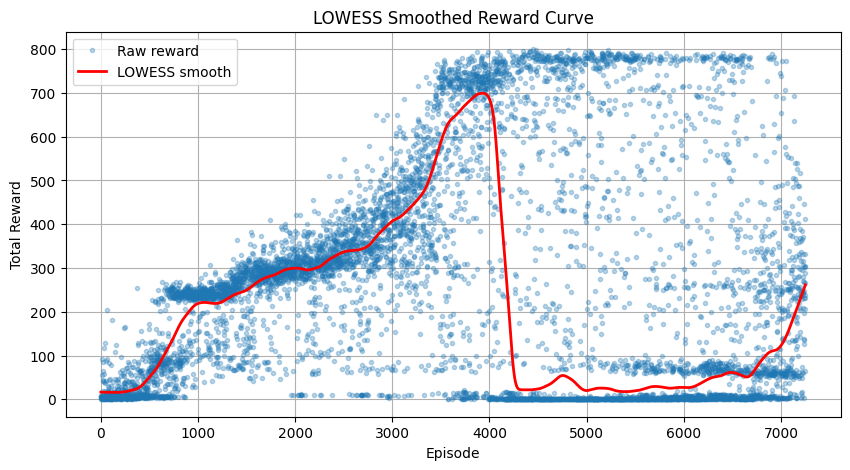

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
!pip install statsmodels --quiet
import statsmodels.api as sm

rewards = grpo_callback.all_rewards
lowess = sm.nonparametric.lowess
smoothed = lowess(rewards, np.arange(len(rewards)), frac=0.05)  # frac controls smoothing

plt.figure(figsize=(10,5))
plt.plot(rewards, '.', alpha=0.3, label='Raw reward')
plt.plot(smoothed[:,0], smoothed[:,1], 'r-', linewidth=2, label='LOWESS smooth')
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("LOWESS Smoothed Reward Curve")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
model.save("ppo_grpo_cartpole_swingup_checkpoint")
print("✅ 模型已成功保存到google drive")

✅ 模型已成功保存到google drive
